
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Logistic Regresion Lab
## Exercise with bank marketing data

_Authors: Sam Stack(DC)_

## Introduction
- Data from the UCI Machine Learning Repository: data, [data dictionary](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Goal**: Predict whether a customer will purchase a bank product marketed over the phone, e.g. if the bank manages itself better, they are more attractive to customer
- `bank-additional.csv` is already in our repo, so there is no need to download the data from the UCI website

## Step 1: Read the data into Pandas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
bank = pd.read_csv('../data/bank.csv')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [3]:
bank.shape

(4119, 21)

In [4]:
bank.loc[3124, :]

age                              24
job                   self-employed
marital                      single
education         university.degree
default                          no
housing                         yes
loan                             no
contact                   telephone
month                           jun
day_of_week                     wed
duration                         40
campaign                          1
pdays                           999
previous                          0
poutcome                nonexistent
emp.var.rate                    1.4
cons.price.idx               94.465
cons.conf.idx                 -41.8
euribor3m                     4.959
nr.employed                  5228.1
y                                 0
Name: 3124, dtype: object

Potential features:

* **default** - has credit in default? yes/no
* **housing** - has housing loan? yes/no
* **loan** - has personal loan? yes/no
* **duration** - last contact duration in seconds
* **campaign** - number of contacts performed for client
* **pdays** - number of days passed by after client was last contacted
* **previous** - number of contacts performed before this campaign
* **poutcome** - outcome of previous marketing campaign
* **emp.var.rate** - employment variation rate (quarterly)
* **cons.price.idx** - consumer price index (monthly)
* **cons.conf.idx** - consumer confidence index (monthly)
* **euribor3m** - euribor 3-month rate (daily) - the higher the rate, the higher the risk for individual
* **nr.employed** - number of employees


**Target '`y`' represents has client subscribed for a term deposit as:**
    - No : 0
    - Yes : 1
    


In [5]:
# Imbalanced dataset - minority have subscribed so maybe under-sampling 
bank['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [11]:
from collections import Counter

default_class = Counter(bank['default'])
housing_class = Counter(bank['housing'])
loan_class = Counter(bank['loan'])

print("Class Distribution for Credit in Default:", default_class)
print("Class Distribution for Housing Loan:", housing_class)
print("Class Distribution for Personal Loan:", loan_class)

Class Distribution for Credit in Default: Counter({'no': 3315, 'unknown': 803, 'yes': 1})
Class Distribution for Housing Loan: Counter({'yes': 2175, 'no': 1839, 'unknown': 105})
Class Distribution for Personal Loan: Counter({'no': 3349, 'yes': 665, 'unknown': 105})


In [12]:
# Map values from previous campaign outcome and add to original df
bank['poutcome_num'] = bank.poutcome.map({'nonexistent': 0, 'failure': 1, 'success': 2})

In [13]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,poutcome_num
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0,0


**Possible numerical variables are:**

    - age
    - poutcome_num
    - emp.var.rate
    - cons.price.idx
    - cons.conf.idx
    - euribor3m
    - nr.employed

In [14]:
numericals = ['age', 'poutcome_num', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

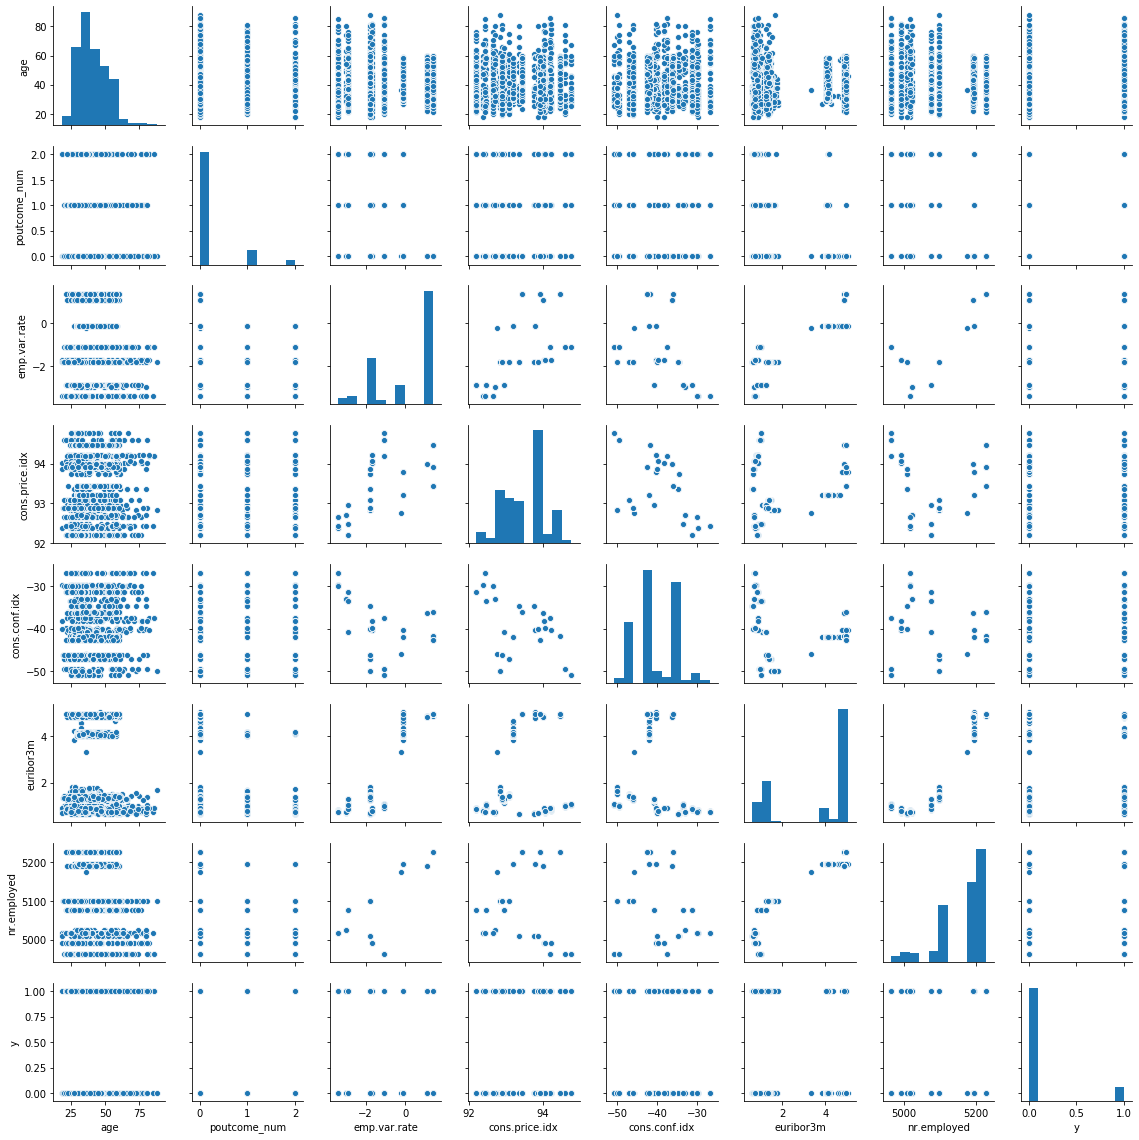

In [15]:
# Variables 'emp.var.rate', 'euribor3m' and 'nr.employed' seem to have strongest trends 
sns.pairplot(bank[numericals], height=2.0)

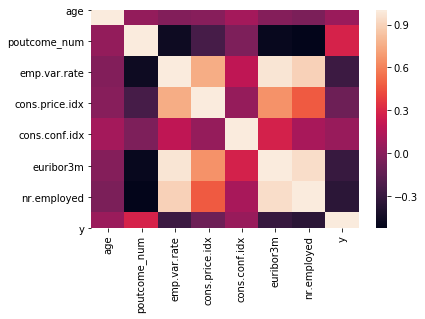

In [16]:
# emp.var.rate and euribor3m are highly correlated
corr_matrix = bank[numericals].corr()
sns.heatmap(corr_matrix)

In [17]:
# Remove 'euribor3m' from numerical features

**Other possible categorical variables are:**

    - job
    - marital
    - education
    - default
    - housing
    - loan

In [18]:
# Clean data (check data for null values)
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
poutcome_num      0
dtype: int64

In [19]:
# Check columns for "unknown" values in other columns (use 'age' as numerical comparison)
unknown_values = ['age','job', 'education']

for unknown in unknown_values:
    if unknown != 'age':
        print(bank[unknown].value_counts())

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: education, dtype: int64



## Step 2: Prepare at least three features
- Include both numeric and categorical features
- Choose features that you think might be related to the response (based on intuition or exploration)
- Think about how to handle missing values in 'housing' and 'loan' (encoded as "unknown"). A sound method of replacing "unknown" is to build model to predict the "unknown" using K-Nearest Neighbors, so that you are filling in an unknown value using the most similar observations you have.

In [14]:
# Numerical features: 'nr.employed', 'emp.var.rate', 'poutcome_num'
# Categorical features: 'housing', 'loan'
# Target feature: 'y'

In [20]:
# 105 unknowns in 'housing' and 'loan' - remove so no additional bias
bank[(bank['housing'] == 'unknown') & (bank['loan'] == 'unknown')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,poutcome_num
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,0
41,38,blue-collar,married,basic.9y,unknown,unknown,unknown,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0,0
87,47,services,single,basic.9y,no,unknown,unknown,telephone,jun,thu,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,1,0
173,41,services,single,high.school,unknown,unknown,unknown,cellular,may,mon,...,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,0,1
375,31,technician,single,professional.course,no,unknown,unknown,cellular,aug,mon,...,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,33,blue-collar,married,basic.9y,no,unknown,unknown,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0,0
4030,37,technician,divorced,professional.course,no,unknown,unknown,cellular,aug,tue,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,0
4042,40,blue-collar,single,basic.9y,no,unknown,unknown,cellular,nov,wed,...,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0,0
4058,47,blue-collar,married,basic.4y,no,unknown,unknown,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,0


In [21]:
# Remove rows with 'unknown' values
unknown_filter = bank['loan'] != 'unknown'
bank_df = bank[unknown_filter]

In [22]:
# Check unique values for 'housing' and 'loan'
bank_df['loan'].value_counts()

no     3349
yes     665
Name: loan, dtype: int64

In [23]:
bank_df['housing'].value_counts()

yes    2175
no     1839
Name: housing, dtype: int64

In [24]:
# You can map binary categories
bank_df['housing_num'] = bank_df.housing.map({'no': 0, 'yes': 1})

C:\Users\shmel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
bank_df['loan_num'] = bank_df.loan.map({'no': 0, 'yes': 1})

C:\Users\shmel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
# Prepare data with mapped categories
feature_cols = ['housing_num', 'loan_num', 'poutcome_num', 'emp.var.rate', 'nr.employed']

In [28]:
# You can use get_dummies for categorical features (it ignores numeric columns) instead of mapping classes
# 'drop_first=True' because features are small and reduces computational effort

#dummy_data = pd.get_dummies(bank_df[['housing', 'loan']], drop_first=True)

# Append to bank_df dataframe
#dummy_bank = pd.concat([bank_df, dummy_data], axis=1)

In [66]:
# See dummy columns
#dummy_bank.head()


## Step 3: Model building
- Use cross-validation to evaluate the logistic regression model with your chosen features.  
    You can use any (combination) of the following metrics to evaluate.
    - [Classification/Accuracy Error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
    - [Confusion Matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
    - [ROC curves and area under a curve (AUC)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
    - [Log loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
- Try to increase the metrics by selecting different sets of features
    - *Bonus*: Experiment with hyper parameters such are regularization.

In [27]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import metrics

**Build Model 1**

No hyper-parameters ('lbfgs' is default value for solver parameter - if not declared, weird warning error thrown)

In [28]:
# set the model
logreg = LogisticRegression(solver='lbfgs')

In [30]:
X = bank_df[feature_cols]
y = bank_df.y

In [31]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
# fit model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Get the Coefficient for each feature.**
- Be sure to make note of interesting findings.



In [33]:
coef = logreg.coef_[0]
coef

array([-1.19104446e-01, -6.30125854e-02,  7.21283064e-01, -4.10378840e-01,
       -4.68268171e-04])

In [34]:
name = bank_df[feature_cols].columns

In [35]:
# 'poutcome_num' carries largest coefficient at 0.72
pd.DataFrame([name, coef], index=['Name','Coef']).transpose()

,Name,Coef
0,housing_num,-0.119104
1,loan_num,-0.0630126
2,poutcome_num,0.721283
3,emp.var.rate,-0.410379
4,nr.employed,-0.000468268


In [36]:
# Reference level for p-outcome is 'no' (0) and odds ratio for coefficient is 2.06, so change is 0.06 and in percentage, 6%
# To calculate odds ratio, exponentiate the coefficient, i.e. the change in odds for 1-unit increase in predictor variable
odds_ratio = np.exp(0.721283)
odds_ratio

2.0570707400664676

In [37]:
# Coefficient for 'poutcome_num' says, with other predictors variables held fixed, we will see 6% increase in odds
# of customer subscribing to term deposit when there is successful previous marketing campaign, 
# since exp(0.721283) = 2.06

**Use the Model to predict on X_test1 and evaluate the model using metric(s) of choice.**

In [38]:
# Store predicted values in new variable
pred = logreg.predict(X_test)

### Use a different combination of metrics.
- Evaluate the model and interpret your chosen metrics.

In [39]:
# Accuracy score is very high, 90% but only slight improvement on baseline of 89%
# Remember that distribution of classes is imbalanced (451 'yes' and 3668 'no') so if we guess 'no',
# we would be correct 89% of the time which is our baseline
# Data set could be unevenly split during train-test split, either way it is better to use F1-score metric
metrics.accuracy_score(y_test, pred)

0.9033864541832669

In [41]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       903
           1       0.70      0.07      0.13       101

    accuracy                           0.90      1004
   macro avg       0.80      0.53      0.54      1004
weighted avg       0.88      0.90      0.87      1004



In [42]:
# Confusion matrix
# 900 True Negatives, 3 False Positives, 94 False Negatives, 7 True Positives
# Our model is mostly predicting 'no'...but we are predicting some True Positives which may indicate low data in test set
metrics.confusion_matrix(y_test, pred)

array([[900,   3],
       [ 94,   7]], dtype=int64)

In [43]:
# AUC score
# 0.53 is very bad - this may be due to train-test split
metrics.roc_auc_score(y_test, pred)

0.5329923357784284

In [44]:
# Log Loss, or Logarithmic Loss
# Value is 3.33 - compare with other models (the lower the value, the better the predictions)
metrics.log_loss(y_test, pred)

3.3369160449189517



### Is your model performing well?

If it is predicting few or no True Positives, we can try one more thing before we revert to adding/changing features - adjusting the probability threshold.

Use the `LogisticRegression.predict_proba()` attribute to get the probabilities.

***Recall from the lesson that the first probability column is for `class 0` and the second column is for `class 1`.***

In [45]:
# Variable storing predicted probabilities for class 1 outcome (True Positives) 
predict_prob = logreg.predict_proba(X_test)[:, 1]

**Visualize the distribution**

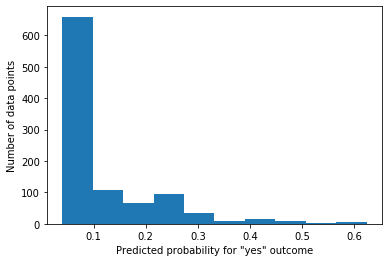

In [46]:
plt.hist(predict_prob)
plt.xlabel('Predicted probability for "yes" outcome');
plt.ylabel('Number of data points');
plt.show();

**Calculate a new threshold and use it to convert predicted probabilities to output classes**



In [47]:
# View distribution to determine probability threshold at approx 0.2
y_pred=[]
for prob in predict_prob:
    if prob > 0.2:
        y_pred.append(1)
    else:
        y_pred.append(0)

# Compare the length of new predicted outcomes with the testing set
print(len(y_pred))
print(len(y_test))

1004
1004


**Evaluate the model metrics now, with the new predicted values in y_pred**

In [48]:
# Accuracy with predicted probabilities in threshold has gotten worse but that may be useful sign
metrics.accuracy_score(y_test, y_pred)

0.8247011952191236

In [49]:
# Confusion matrix with predicted probabilities in threshold - large increase in True Positives (51)
metrics.confusion_matrix(y_test, y_pred)

array([[777, 126],
       [ 50,  51]], dtype=int64)

In [50]:
# AUC score - has improved which makes sense
metrics.roc_auc_score(y_test, y_pred)

0.6827078056642873

In [51]:
# Log loss is a lot higher meaning predictions are a lot worse
metrics.log_loss(y_test, y_pred)

6.05470656850646

As you can see from results above, adjusting the probability threshold did not help which means our initial problem comes from train-test split/imbalanced data set.

## Step 2: Build a second model using all of the features.

- Evaluate it using your preferred metrics.

In [53]:
# Prepare the data (remove rows with 'unknown') and remove poutcome_num column
unknown_filter = bank['loan'] != 'unknown'
model_df = bank[unknown_filter]

In [54]:
df = model_df.drop(['poutcome_num'], axis=1)

In [55]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,...,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,0


In [56]:
# Prepare dummy columns for all categorical features
dummy_df = pd.get_dummies(df)

In [76]:
# Default regularization strength (C)
# Increase max_iter
lgrg = LogisticRegression(solver='lbfgs', C=10, max_iter=10000)

In [77]:
X = dummy_df.drop('y', axis=1)
y = dummy_df['y']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
# Increased max_iter 
lgrg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
dummy_pred = lgrg.predict(X_test)

In [81]:
# Accuracy score (improved)
metrics.accuracy_score(y_test, dummy_pred)

0.9243027888446215

In [82]:
# Confusion matrix (tn, fp, fn, tp) - improved
metrics.confusion_matrix(y_test, dummy_pred)

array([[882,  21],
       [ 55,  46]], dtype=int64)

In [83]:
# AUC score - improved
metrics.roc_auc_score(y_test, dummy_pred)

0.7160948653004835

In [84]:
# Log Loss score - improved
metrics.log_loss(y_test, dummy_pred)

2.614505774461401

## Bonus: Use Regularization to optimize your model.

In [75]:
# Use For loop to evaluate various regularization strengths of 'C' using ROC score (C=10 has highest auc score)
c_values = [0.01, 0.1, 1.0, 10, 100]

for c in c_values:
    logreg = LogisticRegression(solver='lbfgs', C=c, max_iter=10000)
    logreg.fit(X_train, y_train)
    c_predictions = logreg.predict(X_test)
    roc = metrics.roc_auc_score(y_test, c_predictions)
    print(roc," : ", c)

0.6946646491891714  :  0.01
0.6918960999089943  :  0.1
0.7050864554894027  :  1.0
0.7160948653004835  :  10
0.7056401653454382  :  100


It looks like the dummy-encoding and hyperparameters have helped our model performance.

Now, train new Logistic model set with L1 regularization using 'liblinear' solver, and find optimal 'C' value to ascertain whether that is more efficient:

In [95]:
# L1 penalty only works with 'liblinear' or 'saga' solvers
# 'liblinear' solver works better with smaller datasets
log_reg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=1000)

In [96]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
solver_pred = log_reg.predict(X_test)

In [98]:
# Accuracy score - slightly worse
metrics.accuracy_score(y_test, solver_pred)

0.9252988047808764

In [99]:
# Confusion matrix (tn, fp, fn, tp) - same
metrics.confusion_matrix(y_test, solver_pred)

array([[887,  16],
       [ 59,  42]], dtype=int64)

In [100]:
# AUC score - slightly worse
metrics.roc_auc_score(y_test, solver_pred)

0.699061434382641

In [101]:
# Log Loss score - slightly worse
metrics.log_loss(y_test, solver_pred)

2.5801006206944073

In [94]:
# Use For loop to evaluate different regularization strengths
c_values = [0.01, 0.1, 1.0, 10, 100]

for c in c_values:
    logreg = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=1000)
    logreg.fit(X_train, y_train)
    predictions = logreg.predict(X_test)
    roc = metrics.roc_auc_score(y_test, predictions)
    print(roc," : ", c)

0.6594574739866014  :  0.01
0.699061434382641  :  0.1
0.6957391752464283  :  1.0
0.6907886801969233  :  10
0.6907886801969233  :  100


In [ ]:
# Generally more features improves model performance
# 'lbfgs' using L2 regularization at strength C=10 indicates best model performance 